In [1]:
%reload_ext autoreload

import numpy as np
import os
import argparse
import collections
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
import matplotlib.pyplot as plt

import precision_recall_scores as prs
import iotools
import get_plotvals

In [12]:
whichplot = ['blore2', 'blore3', 'blore4', 'finemap2', 'finemap5', 'finemap10']
#whichplot = ['blore2', 'blore3', 'blore4', 'finemap2', 'finemap5']
#whichplot = ['blore2', 'blore3', 'finemap2', 'finemap5']
basedir = '/scratch/sbanerj/quasi_laplace_gwas/simulations/'
locusfile = '/scratch/sbanerj/quasi_laplace_gwas/LOCUSNAMES.50NLOCI'
startsim = 121
endsim = 180
use_credible = True

In [13]:
locusprefixes = iotools.read_locusprefixes(locusfile)
nclist = list()

cmax = {'blore2': 2,
        'blore3': 3,
        'blore4': 4,
        'blore5': 5,
        'finemap2': 2,
        'finemap5': 5,
        'finemap10': 10,
       }

res = collections.defaultdict(lambda:0)
for key in whichplot:
    res[key] = list()

exclude = [126, 134, 175, 176]
#exclude = [722, 724, 726, 728, 734, 736, 738, 739, 740, ]
#include = [652, 653, 657, 658, 660, 661, 664, 665, 667, 669, 670, 671, 672, 673, 674, 677, 678, 679, 681, 
#          684, 685, 686, 687, 688, 689, 690, 692, 693, 694, 695, 696, 697, 698, 699]

nsim = 0
for sim in range(startsim, endsim + 1):
    if sim not in exclude:
        nsim += 1
        simname = 'sim{:03d}'.format(sim)
        print ('Reading {:s}'.format(simname))
        simdir = os.path.join( basedir, simname)
        causal_snps_file = os.path.join(simdir, 'samples', 'causal.snplist')
        causal_rsids = iotools.read_causal_rsids(causal_snps_file)
        nclist += [len(val) for key, val in causal_rsids.items() ][1:]
        for key in whichplot:
            thisres = iotools.read_simres(simdir, key, locusprefixes, causal_rsids, cmax[key], '0')
            res[key].append(thisres)

Reading sim041
Reading sim042
Reading sim043
Reading sim044
Reading sim045
Reading sim046
Reading sim047
Reading sim048
Reading sim049
Reading sim050
Reading sim051
Reading sim052
Reading sim053
Reading sim054
Reading sim055
Reading sim056
Reading sim057
Reading sim058
Reading sim059
Reading sim060


In [14]:
nmax = 0
plotvals = collections.defaultdict(lambda:0)
for key in whichplot:
    if use_credible:
        data = list()
        for x in res[key]:
            data += x
    else:
        data = [[y for z in x for y in z] for x in res[key]]
    maxlen = max([len(x) for x in data])
    if maxlen > nmax:
        nmax = maxlen
    plotvals[key] = get_plotvals.precision_recall_threshold(data)
    #plotvals[key] = precision_recall_threshold(data)

In [15]:
xlim = [0, int(0.15 * nmax)]
ylim = [0, 0.9]
xticks = None
yticks = np.arange(0, 1, 0.2)

In [19]:
# http://ksrowell.com/blog-visualizing-data/2012/02/02/optimal-colors-for-graphs/

kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray

    # The following don't work well for people with defective color vision
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

banskt_colors_hex = ['#FF6800', '#E36A24', '#CC2529', '#93AA00', '#007D34', '#232C16']

def coreplot(ax, xvals, yvals, ystd, color, myls, mlabel, mzorder, markstart, markstyle):
    yupper = np.minimum(yvals + ystd, 1)
    ylower = yvals - ystd
    color = color
    linestyle = myls
    
    markersize = 16
    coef = 12
    _dash = 1
    _dot = 0.3
    _dashspace = 0.8
    _dotspace = 0.5
    mydash = []
    if myls == 'solid':
        mydash = []
    elif myls == 'dashed':
        mydash = [_dash, _dashspace]
    elif myls == 'dotted':
        mydash = [_dot, _dotspace]
    elif myls == 'dashdot':
        mydash = [_dash, _dashspace, _dot, _dashspace]
    elif myls == 'dashdotdot':
        mydash = [_dash, _dashspace, _dot, _dashspace, _dot, _dashspace]
    elif myls == 'dashdashdot':
        mydash = [_dash, _dashspace, _dashspace, _dashspace, _dot, _dashspace]
    mydash = [x * coef for x in mydash]
    
    if markstyle == 'D':
        myms = int(0.9 * markersize)
    elif markstyle == 's':
        myms = int(0.9 * markersize)
    elif markstyle == 'p':
        myms = int(1.15 * markersize)
    else:
        myms = markersize

    ax.plot(xvals, yvals, color=color, dashes = mydash, lw=4, label=mlabel, zorder=mzorder,
           marker=markstyle, markevery= (markstart, 10), ms = myms, 
           markerfacecolor=color, markeredgecolor='black', markeredgewidth=1, )
    return

def add_inset(fig, ax, hfrac, vfrac, hoffset, voffset):
    bbox = ax.get_position()
    iax_left   = bbox.x0 + hoffset * bbox.width
    iax_bottom = bbox.y0 + voffset * bbox.height
    iax_width  = hfrac * bbox.width
    iax_height = vfrac * bbox.height
    iax = fig.add_axes([iax_left, iax_bottom, iax_width, iax_height])
    return iax

def cdistplot(iax, nc, nsim, bordercolor, borderwidth, label_font_size, axis_font_size, mxlabel, mylabel):
    
    cmin = 1
    cmax = 6
    xscalar = list()
    yheight = list()
    mlabels = list()
    for i in range(cmin, cmax + 1):
        xscalar.append(i)
        yheight.append(nc.count(i) / nsim)
        mlabels.append('{:d}'.format(i))
    iax.bar(xscalar, yheight, color='#B2B7B7', tick_label = mlabels, align = 'center')
    iax.set_xlim(cmin - 0.5, cmax + 0.5)
    iax.set_ylim(0, 1.1 * max(yheight))
    #iax.set_yticks([0, 20, 40, 60])

    iax.tick_params(axis='both', which = 'major',
                   length = 4, width = borderwidth, pad=5,
                   #direction = 'out',
                   labelsize = label_font_size,
                   color = bordercolor,
                   labelcolor = bordercolor,
                   bottom = True, top = False, left = True, right = True
                  )
    
    xticks = iax.get_xticks()
    yticks = iax.get_yticks()
    xticklabels = ['{:g}'.format(x) for x in xticks]
    yticklabels = ['{:g}'.format(x) for x in yticks]
    iax.set_xticklabels(xticklabels, font_properties)
    iax.set_yticklabels(yticklabels, font_properties)

    for side, border in iax.spines.items():
        border.set_linewidth(borderwidth)
        border.set_color(bordercolor)

    iax.set_xlabel(mxlabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 5)
    iax.set_ylabel(mylabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 5)
    return

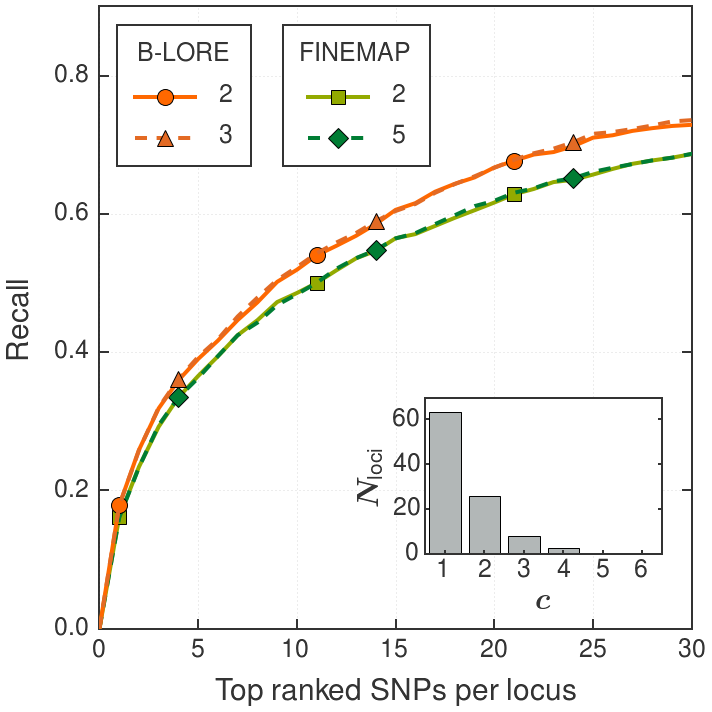

In [21]:
bordercolor = '#333333'
borderwidth = 2
colors = banskt_colors_hex
figsize = (10, 10)
axis_font_size = 30
label_font_size = 25
legend_font_size = 25


fig = plt.figure(figsize = figsize)
ax1 = fig.add_subplot(111)

mlabels = {'blore2':    '2',
           'blore3':    '3',
           'blore4':    '4',
           'blore5':    '5',
           'finemap2':  '2',
           'finemap5':  '5',
           'finemap10': '8',
          }

mcolors = {'blore2':   colors[0],
           'blore3':   colors[1],
           'blore4':   colors[2],
           'blore5':   colors[0],
           'finemap2': colors[3],
           'finemap5': colors[4],
           'finemap10':colors[5],
          }

mzorder = {'blore2':    70,
           'blore3':    80,
           'blore4':    90,
           'blore5':   100,
           'finemap2':  40,
           'finemap5':  50,
           'finemap10': 60,
          }

mdash = {'blore2':    'solid',
         'blore3':    'dashed',
         'blore4':    'dotted',
         'blore5':    'dashdot',
         'finemap2':  'solid',
         'finemap5':  'dashed',
         'finemap10': 'dotted',
        }

mmarker = {'blore2':    'o',
           'blore3':    '^',
           'blore4':    'v',
           'blore5':    '<',
           'finemap2':  's',
           'finemap5':  'D',
           'finemap10': 'p',
          }

mpos = {'blore2': 1,
        'blore3': 4,
        'blore4': 7,
        'blore5': 7,
        'finemap2': 1,
        'finemap5': 4,
        'finemap10': 7,
       }

for key in ['blore2', 'blore3', 'blore4', 'finemap2', 'finemap5', 'finemap10']:
    val = plotvals[key]
    if not val == 0:
        if len(val[0]) > 0:
            x = val[0]
            y = val[2]
            err = val[4]
            coreplot(ax1, x, y, err, mcolors[key], mdash[key], mlabels[key], mzorder[key], 
                     mpos[key], mmarker[key])

mxlabel = r'Top ranked SNPs per locus'
mylabel = r'Recall'
font_properties = {'family':'sans-serif', 'weight': 'bold', 'size': axis_font_size, 'color':bordercolor}
ax1.set_xlabel(mxlabel, font_properties, labelpad = 15)
ax1.set_ylabel(mylabel, font_properties, labelpad = 20)

for ax in [ax1]:
    if xlim is not None: ax.set_xlim(xlim)
    if ylim is not None: ax.set_ylim(ylim)
    if xticks is not None: ax.set_xticks(xticks)
    if yticks is not None: ax.set_yticks(yticks)

    h, l = ax.get_legend_handles_labels()
    if len(l) > 0:
        legend1 = ax.legend(handles = h[:3], loc='upper left', bbox_to_anchor=(0.02, 0.98),
                           handlelength = 5.0,
                           handletextpad = 2.0,
                           numpoints = 1,
                           markerscale=1,
                           ncol = 1,
                           frameon = True, borderpad = 1.5, labelspacing = 1.5,
                           title = 'B-LORE',
                          )
        legend2 = ax.legend(handles = h[3:], loc='upper left', bbox_to_anchor=(0.3, 0.98),
                           handlelength = 5.0,
                           handletextpad = 2.0,
                           numpoints = 1,
                           markerscale=1, 
                           ncol = 1,
                           frameon = True, borderpad = 1.5, labelspacing = 1.5,
                           title = 'FINEMAP',
                          )
        ax.add_artist(legend1)
        ax.add_artist(legend2)
        for l in legend1.legendHandles + legend2.legendHandles:
            l.set_alpha(1)
        for lframe in [legend1.get_frame(), legend2.get_frame()]:
            lframe.set_edgecolor(bordercolor)
            lframe.set_linewidth(borderwidth)
        for fonts in ([legend1.get_title()] + legend1.texts + [legend2.get_title()] + legend2.texts):
            fonts.set_fontsize(legend_font_size)
            fonts.set_color(bordercolor)

    ax.tick_params(axis='both', which = 'major',
                   length = 10, width = borderwidth, pad=10,
                   labelsize = label_font_size,
                   color = bordercolor,
                   labelcolor = bordercolor,
                   bottom = True, top = False, left = True, right = True
                  )

    font_properties = {'family':'sans-serif', 'weight': 'bold', 'size': label_font_size}
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()
    xticklabels = ['{:g}'.format(x) for x in xticks]
    yticklabels = ['{:3.1f}'.format(x) for x in yticks]
    ax.set_xticklabels(xticklabels, font_properties)
    ax.set_yticklabels(yticklabels, font_properties)
        
    for side, border in ax.spines.items():
        border.set_linewidth(borderwidth)
        border.set_color(bordercolor)
    ax.grid(color='dimgray', lw=0.5, alpha=0.5)

plt.tight_layout()
iax = add_inset(fig, ax1, 0.4, 0.25, 0.55, 0.12)
mxlabel = r"$\boldsymbol{c}$"
mylabel = r"$\boldsymbol{N_\text{loci}}$"
cdistplot(iax, nclist, nsim, bordercolor, borderwidth, 0.8 * label_font_size, axis_font_size, mxlabel, mylabel)
plt.savefig('pip_prc_cvar01.png', bbox_inches='tight')
plt.savefig('pip_prc_cvar01.pdf', bbox_inches='tight')
plt.show()